In [119]:
import torch
import numpy as np
import scipy.io as sio
import os

In [120]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [121]:
# Paramètres du modèle
N = 2 # dim de l'input x
m = 10 # dim de l'output y
T = 1 # borne sup pour x
nb_points = 10 
nb_maps = 100 # nombre d'images que l'on va générer
nb_blocks = 2 # nombre de blocs dans le modèle
M = 10 # nombre d'échantillons pour l'approximation de Monte Carlo

In [122]:
omega = torch.tensor([[0, 1] for _ in range(N)])
X = torch.zeros((nb_maps, nb_points, N))

for _ in range(nb_maps):
    x = torch.rand(nb_points, N) * (omega[:, 1] - omega[:, 0]) + omega[:, 0] # all the coordinates of x are between 0 and 1
    X[_, :, :] = x
X = torch.Tensor(np.expand_dims(X, axis=1))
print(f'La dimension de x est {x.size()}')

La dimension de x est torch.Size([10, 2])


In [157]:
class Block(torch.nn.Module):
    def __init__(self, m) -> None:
        super(Block, self).__init__()
        self.fc = torch.nn.Linear(m, m)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        identity = x
        x = self.fc(x)
        x = self.activation(x)
        x = self.fc(x)
        x = self.activation(x)
        return x + identity
    
class Model(torch.nn.Module):
    def __init__(self, N, m, nb_blocks) -> None:
        super(Model, self).__init__()
        self.fc_in = torch.nn.Linear(N, m)
        self.blocks = torch.nn.ModuleList([Block(m) for _ in range(nb_blocks)])

    def forward(self, x):
        x = self.fc_in(x)
        for block in self.blocks:
            x = block(x)
        return x

In [124]:
def conv(x : torch.Tensor, dx = True, delta : float = 1/nb_points) -> torch.Tensor:
    if dx:
        convx = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if j == 0 :
                    convx[i, j] = (x[i, j+1] - x[i, j])/delta # forward 
                elif j == x.shape[1] - 1:
                    convx[i, j] = (x[i, j] - x[i, j-1])/delta # backward
                else:
                    convx[i, j] = (x[i, j+1] - x[i, j-1])/(2*delta) # central
        return convx
    else:
        convy = torch.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if i == 0 :
                    convy[i, j] = (x[i+1, j] - x[i, j])/delta # forward
                elif i == x.shape[0] - 1:
                    convy[i, j] = (x[i, j] - x[i-1, j])/delta # backward
                else:
                    convy[i, j] = (x[i+1, j] - x[i-1, j])/(2*delta) # central
        return convy

In [125]:
import scipy.io as sio
source_term = sio.loadmat('source_term.mat')
u = sio.loadmat('u.mat')

source_term = torch.Tensor(np.expand_dims(source_term['source_term'], axis=1))
u = torch.Tensor(np.expand_dims(u['u'], axis=1))

torch.Size([100, 1, 10, 10])


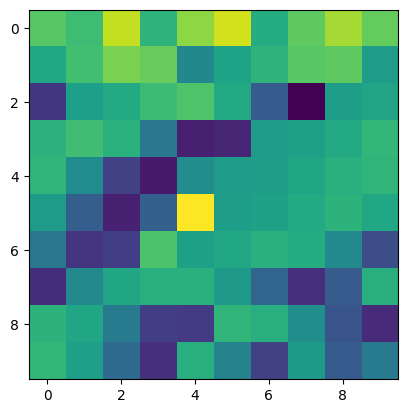

In [167]:
import matplotlib.pyplot as plt
plt.imshow(source_term[0, 0, :, :])

Loss : 11.565750122070312
Loss : 11.506061553955078
Loss : 11.44660758972168
Loss : 11.387394905090332
Loss : 11.328448295593262
Loss : 11.269776344299316
Loss : 11.211383819580078
Loss : 11.153276443481445
Loss : 11.095452308654785
Loss : 11.037917137145996
Loss : 10.980667114257812
Loss : 10.923702239990234
Loss : 10.867021560668945
Loss : 10.810625076293945
Loss : 10.754510879516602
Loss : 10.698674201965332
Loss : 10.64311408996582
Loss : 10.587831497192383
Loss : 10.53282356262207
Loss : 10.478086471557617
Loss : 10.423620223999023
Loss : 10.369421005249023
Loss : 10.315491676330566
Loss : 10.261826515197754
Loss : 10.208429336547852
Loss : 10.155292510986328
Loss : 10.102416038513184
Loss : 10.04980182647705
Loss : 9.997446060180664
Loss : 9.94534969329834
Loss : 9.893509864807129
Loss : 9.841925621032715
Loss : 9.790596008300781
Loss : 9.739521980285645
Loss : 9.688697814941406
Loss : 9.6381254196167
Loss : 9.58780288696289
Loss : 9.537729263305664
Loss : 9.48790454864502
Loss :

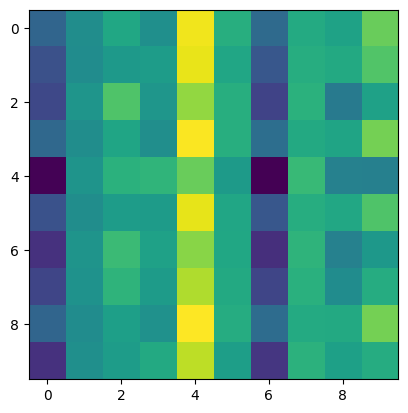

In [178]:
# Code simple pour une seule image
lr = 1e-4
beta_1 = 0.5
beta_2 = 0.999

gen = Model(N, m, nb_blocks)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
source_term_0 = source_term[0, 0, :, :]

cur_steps = 0
# Monte Carlo
# for _ in range(10) :
while cur_steps < 100:
    gen_opt.zero_grad()

    output = gen(x)
    output_dx, output_dy = conv(output), conv(output, dx = False)
    L1, L2 = torch.pow(output_dx, 2), torch.pow(output_dy, 2)
    L1, L2 = torch.sum(L1)/(L1.shape[0]*L1.shape[1]), torch.sum(L2)/(L2.shape[0]*L2.shape[1])
    L3 = torch.sum(source_term_0*output) / (source_term_0.shape[0]*source_term_0.shape[1])

    loss = (L1 + L2)/2 - L3
    loss.backward()
    gen_opt.step()
    cur_steps += 1
    print(f'Loss : {loss}')
plt.imshow(output.detach().numpy())
plt.show()

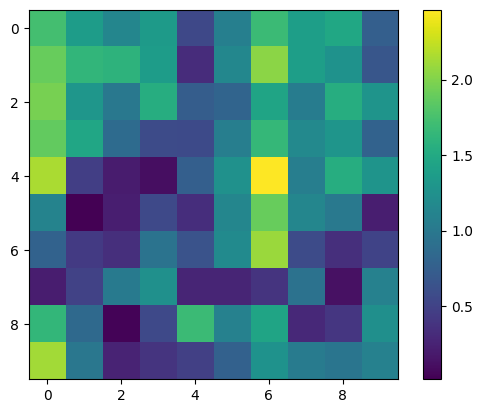

In [179]:
plt.imshow(np.abs(u[0, 0, :, :] - output.detach().numpy()))
plt.colorbar()

In [96]:
gen = Model(N, m, nb_blocks)
output = gen(X)
output_dX, output_dY = torch.zeros(output.shape), torch.zeros(output.shape)

for i, out in enumerate(output) :
    output_dx, output_dy = conv(out[0]), conv(out[0], dx = False)
    output_dx, output_dy = output_dx.expand(1, 1, -1, -1), output_dy.expand(1, 1, -1, -1)
    output_dX[i, :, :, :], output_dY[i, :, :, :] = output_dx, output_dy
    
L1, L2 = torch.pow(output_dX, 2)/2, torch.pow(output_dY, 2)/2
# gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-4)

torch.Size([100, 1, 10, 10])
